# Цель

```
Выбрать любой датасет для задачи бинарной классификации
Построение и настройка модели случайного леса. Визуализация важности признаков.
```

# Датасет

Сторонняя компания по страхованию путешествий, базирующаяся в Сингапуре.

#| Attributes | Признаки
-|-|-
1. |Target: Claim Status (Claim.Status) | Целевая переменная: Статус заявки
2. |Name of agency (Agency) | Наименование агентства
3. |Type of travel insurance agencies (Agency.Type) | Тип туристических страховых агентств
4. |Distribution channel of travel insurance agencies (Distribution.Channel) | Канал распространения туристических страховых агентств
5. |Name of the travel insurance products (Product.Name) | Название продуктов страхования путешествий
6. |Duration of travel (Duration) | Продолжительность путешествия
7. |Destination of travel (Destination) | Пункт назначения
8. |Amount of sales of travel insurance policies (Net.Sales) | Объем продаж полисов страхования путешествий
9. |Commission received for travel insurance agency (Commission) | Комиссия, полученная для туристического страхового агентства
10. |Gender of insured (Gender) | Пол застрахованного
11. |Age of insured (Age) | Возраст застрахованного

https://www.kaggle.com/mhdzahier/travel-insurance

In [93]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Functions

In [40]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
def get_categories_percent(category, percent_threshold):
    """function return a dictinary of lists tuple.
    """
    df_tmp = pd.DataFrame(df[category].value_counts())
    df_tmp = df_tmp * 100 / len(df)
    df_tmp = df_tmp.sort_values(category)
    percent_sum = 0
    category_less_threshold = []
    for index,row in df_tmp.iterrows():
        
        if percent_sum+row[0] <= percent_threshold: 
            percent_sum += row[0]
            category_less_threshold.append(index)
        else:
            break
    
    category_more_threshold = df_tmp[~df_tmp[category].isin(category_less_threshold)].index.tolist()
    
    return {'less':(category_less_threshold,percent_sum),'more':(category_more_threshold,100 - percent_sum)}

def importance_plot(df, model_coef, figsize=(10,6)):
    featureImportance = pd.DataFrame({"feature": df.columns, 
                                  "importance": model_coef})
    
    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)
    featureImportance["importance"].plot('bar', figsize=figsize);
    
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    
def plot_confusion_matrix(y_test, y_score):
    cm = confusion_matrix(y_test, y_score)
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);
    
def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

# 1. EDA

Загрузим датасет из файла.

In [3]:
df = pd.read_csv('data/travel insurance.csv')
print("Строк: {0[0]}, признаков: {0[1]}".format(df.shape))
df.head()

Строк: 63326, признаков: 11


,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.00,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.00,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.50,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.60,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.80,11.88,NaN,41


## 1.1 Анализ целевой переменной

Целевая переменная `Claim`. Значение `1` указывает на обращение по страховому случаю.

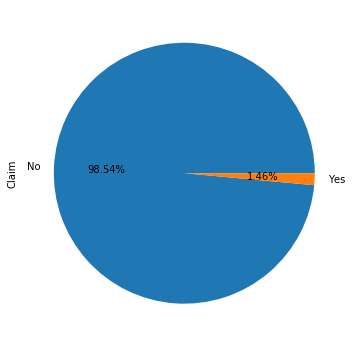

In [4]:
df['Claim'].value_counts().plot(kind='pie', autopct='%1.2f%%', figsize=(8, 6))

График показывает высокий дизбаланс, значит при обучении необходимо проводить `undersampling`.

In [5]:
target_count = df['Claim'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 62399
Class 1: 927
Proportion: 67.31 : 1


Дизабаланс целевой переменной 67 к 1.

## 1.2 Анализ признаков

Выведем информацию по пропускам и типам.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
Agency                  63326 non-null object
Agency Type             63326 non-null object
Distribution Channel    63326 non-null object
Product Name            63326 non-null object
Claim                   63326 non-null object
Duration                63326 non-null int64
Destination             63326 non-null object
Net Sales               63326 non-null float64
Commision (in value)    63326 non-null float64
Gender                  18219 non-null object
Age                     63326 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


Категориальные признаки (6): `Agency, Agency Type, Distribution Channel, Product Name, Destination, Gender`

Числовые признаки (4): `Duration, Net Sales, Commision (in value), Age`

В признаке Gender пропущено `71.23` значений

Посмотрим распределение категориальных признаков относительно их количества.

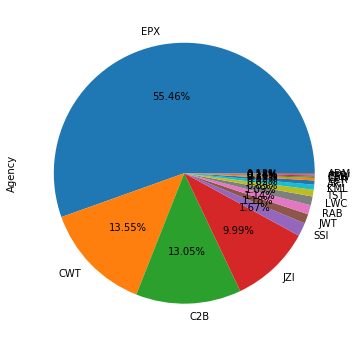

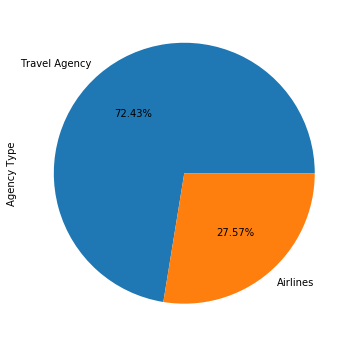

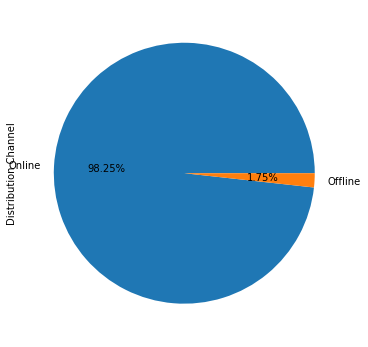

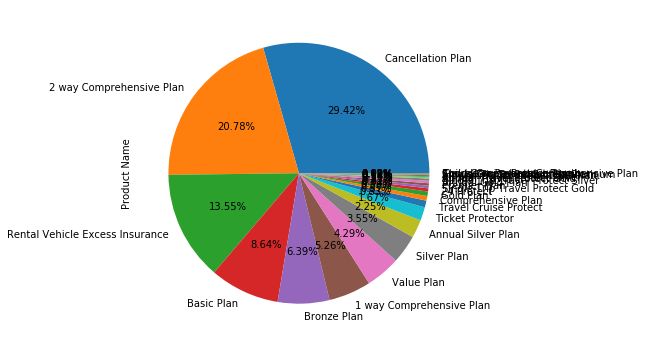

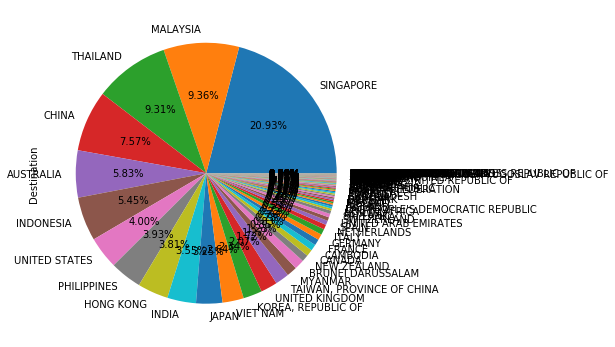

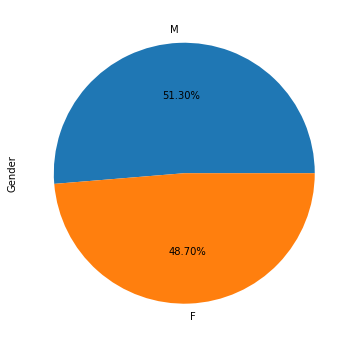

In [155]:
categorial_futures = df.drop(['Claim'], axis=1).select_dtypes(include=np.object)
for future in categorial_futures:
    df[future].value_counts().plot(kind='pie', autopct='%1.2f%%', figsize=(8, 6))
    plt.show();

# 1.2 Преобразование признаков

Производем замену категариальных признаков на `other`, количество которых в сумме менее 10%. Также преобразуем признак `Gender`, где все значения `Nan` приведем к строковому значению `'N'`.

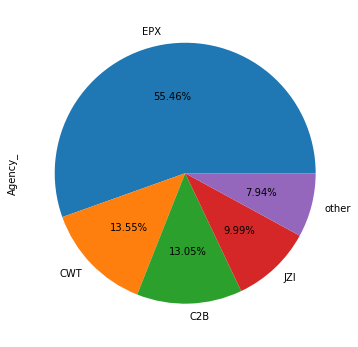

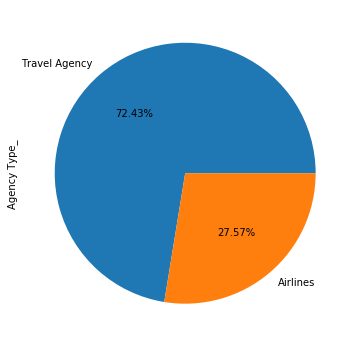

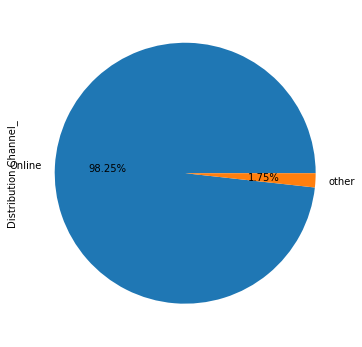

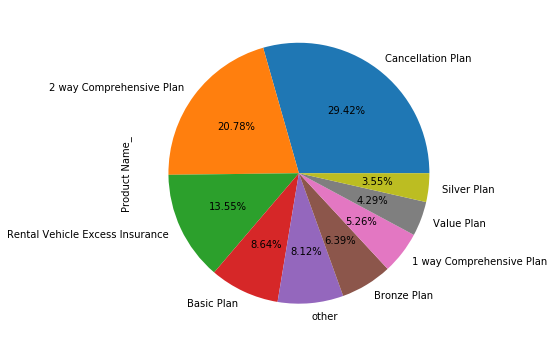

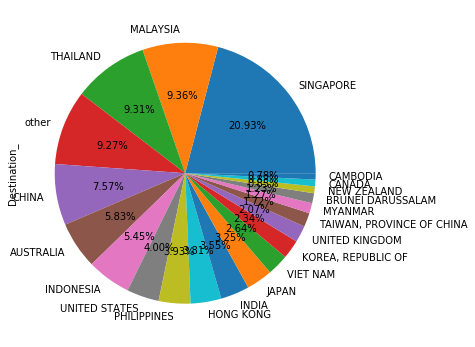

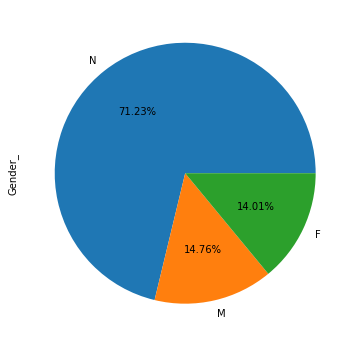

In [156]:
df2 = df.copy(deep=True)

categorial_futures = df.drop(['Claim'], axis=1).select_dtypes(include=np.object)

for future in categorial_futures:
    category_less_5 = get_categories_percent(future, 10)['less'][0]
    df2[future+'_'] = df[future].apply(lambda x: 'other' if x in category_less_5 else x)
    del df2[future]

df2['Claim'] = df2['Claim'].map({'No':0,'Yes':1})
df2['Gender_'] = df2['Gender_'].apply(lambda x: 'N' if x is np.NaN else x)
    
categorial_futures = df2.drop(['Claim'], axis=1).select_dtypes(include=np.object)
for future in categorial_futures:
    df2[future].value_counts().plot(kind='pie', autopct='%1.2f%%', figsize=(8, 6))
    plt.show();

Разделим выборку на тренировочну и тестовую с учетом распределения целевой переменной.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(['Claim'], axis=1), 
    df2['Claim'], 
    stratify=df['Claim'],
    random_state=42
)

Проверим пропорцию на начальную пропорцию `67 к 1`.

In [11]:
train_target_count = y_train.value_counts()
print('Train Class 0:', train_target_count[0])
print('Train Class 1:', train_target_count[1])
print('Train Proportion:', round(train_target_count[0] / train_target_count[1], 2), ': 1')

test_target_count = y_test.value_counts()
print('\nTest Class 0:', test_target_count[0])
print('Test Class 1:', test_target_count[1])
print('Test Proportion:', round(test_target_count[0] / test_target_count[1], 2), ': 1')

Train Class 0: 46799
Train Class 1: 695
Train Proportion: 67.34 : 1

Test Class 0: 15600
Test Class 1: 232
Test Proportion: 67.24 : 1


Произведем OneHot кодирование категориальных признаков для тренировочной и тестовой выборок.

In [12]:
categorial_futures = X_train.select_dtypes(include=np.object).columns.tolist()

X_train_encoded = pd.get_dummies(X_train, columns=categorial_futures)
X_test_encoded = pd.get_dummies(X_test, columns=categorial_futures)

print("Train size:{0[0]}, futures:{0[1]}".format(X_train.shape))
print("Test  size:{0[0]}, futures:{0[1]}".format(X_test.shape))

Train size:47494, futures:10
Test  size:15832, futures:10


На числовыми признаками сделаем МинМак шкалирование.

In [13]:
numeric_futures = X_train_encoded.select_dtypes(include=[np.int64,np.float64]).columns.tolist()
mms = MinMaxScaler().fit(X_train_encoded[numeric_futures])

X_train_encoded_scale, X_test_encoded_scale = X_train_encoded.copy(), X_test_encoded.copy()

X_train_encoded_scale[numeric_futures] = mms.transform(X_train_encoded[numeric_futures])
X_test_encoded_scale[numeric_futures] = mms.transform(X_test_encoded[numeric_futures])

In [57]:
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler, ClusterCentroids

Using TensorFlow backend.


In [67]:
cn = ClusterCentroids(random_state=42)
X_test_encoded_scale_resample, y_train_resample = cn.fit_resample(X_train_encoded_scale, y_train)

# 2. Baseline

В качестве базовой модели выберем RandomForest co стандартными параметрами.

In [179]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_test_encoded_scale_resample, y_train_resample)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [183]:
y_pred = rnd_clf.predict(X_test_encoded_scale)

quality_report(y_pred, y_test)

Accuracy: 0.422
Precision: 0.841
Recall: 0.021
f1_score: 0.041


Базовая модель имеет низкую долю правильных ответов (acuracity), но неполохую точность (precision).

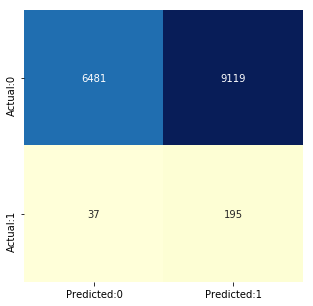

In [184]:
plot_confusion_matrix(y_test,y_pred)

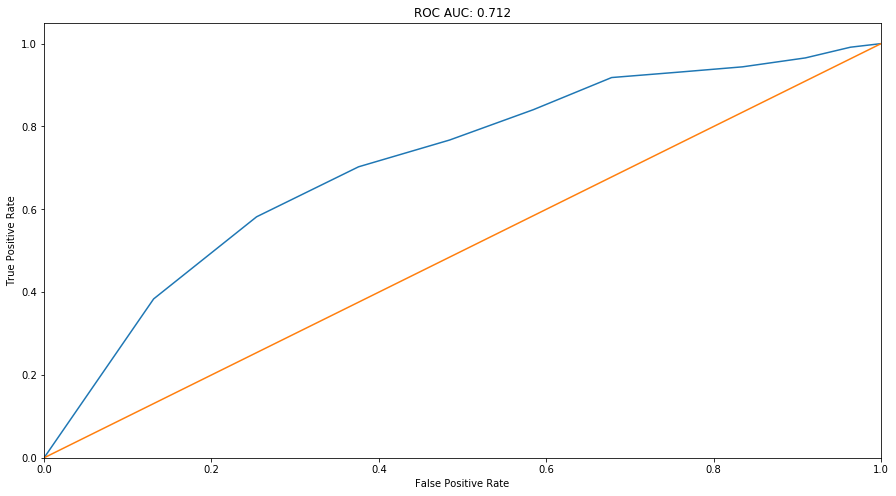

In [185]:
plot_roc_curve(rnd_clf.predict_proba(X_test_encoded_scale)[:,1], y_test);

Построим график важности признаков, чтобы в дальнейшем сравнить его с лучшей моделью.

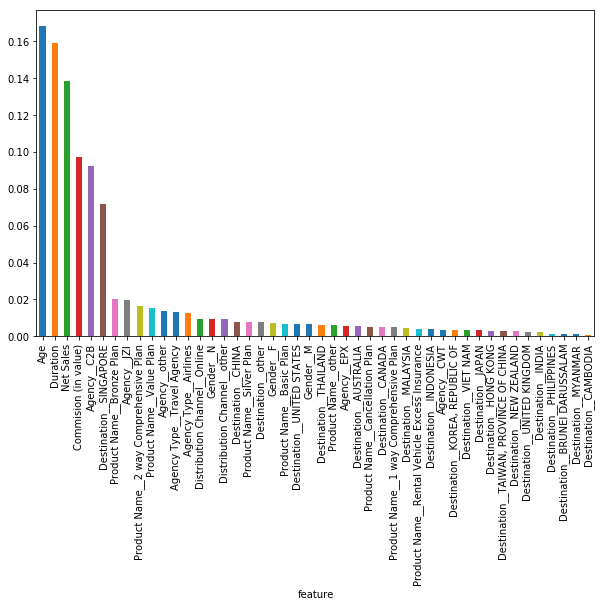

In [80]:
importance_plot(X_train_encoded_scale,rnd_clf.feature_importances_);

# 3. RandomForest

Для нашей базовой модели подберем гиперпараметры через `GridSearchCV`.

In [105]:
%%time
param_grid = { 
    'n_estimators': [100,200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rnd_clf, param_grid=param_grid, cv= 5, scoring='precision')
CV_rfc.fit(X_test_encoded_scale_resample, y_train_resample)

CPU times: user 3min 36s, sys: 22 s, total: 3min 58s
Wall time: 6min 8s


In [187]:
y_pred = CV_rfc.best_estimator_.predict(X_test_encoded_scale)
quality_report(y_pred, y_test)

Accuracy: 0.758
Precision: 0.720
Recall: 0.042
f1_score: 0.080


Модель получилось значительно лучше, мы смогли увеличить долю правильных ответов (accuracity) и полноту (recall), но немного потеряли в точности.

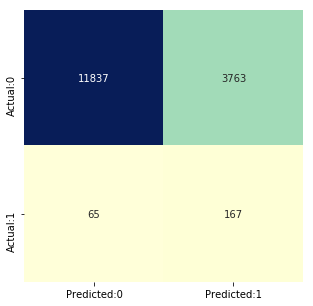

In [188]:
plot_confusion_matrix(y_test,y_pred)

Из матрицы видно, что чуть хуже стали предсказывать страховые случаи, зато уменьшили количество ложных предсказаний.

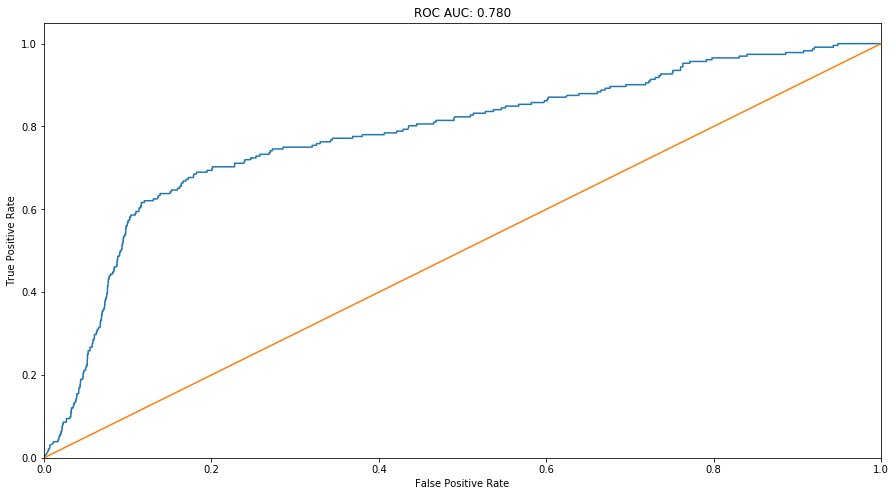

In [189]:
plot_roc_curve(CV_rfc.best_estimator_.predict_proba(X_test_encoded_scale)[:,1], y_test);

Построим график важности признаков нашей улчушенной модели.

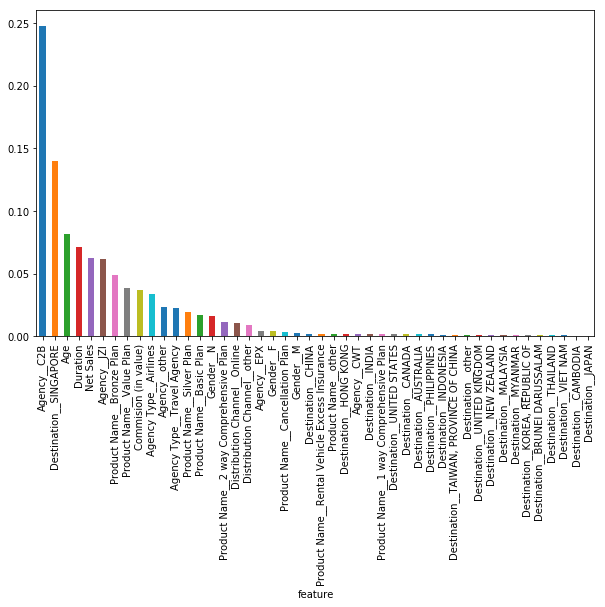

In [190]:
importance_plot(X_train_encoded_scale,CV_rfc.best_estimator_.feature_importances_);

# Выводы

Из график видно, что на возникновение страхового случая влияют следующие факторы:
1. Путевка преобреталась в агенстве C2B
1. Клиенты были из Сингапура
1. Вероятно есть определенный дипазон возрастов, где вероятность страхового случая выше
1. Длительность путешествия влияет напрямую